In [1]:
import GPy
import openeo
import rasterio
from shapely.geometry import box
import pandas as pd
import numpy as np
from openeo.rest.conversions import timeseries_json_to_pandas
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

In [2]:
#connect with VITO backend
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [3]:
spat_ext = {"west":-4.8909914254212605,"east":-4.820438599493526,"south":41.74687686378393,"north":41.79965426256652}
temp_ext = ["2015-11-20","2021-01-31"]

In [4]:
from openeo.processes import eq
s1_desc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'DESCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )


VH = s1_desc.band("VH")
VV = s1_desc.band("VV")
rvi_desc_cube = (VH + VH) / (VV + VH)

s1_asc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'ASCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
VH = s1_asc.band("VH")
VV = s1_asc.band("VV")
rvi_asc_cube = (VH + VH) / (VV + VH)

scl = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["SCL"])
cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)
s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08"])
s2 = s2.mask(cloud_mask)
ndvi_cube = s2.ndvi(red="B04", nir="B08")

In [5]:
from shapely.geometry import box
subsets = {
    'Rye' : box(-4.867495201109149, 41.77850665915476, -4.865177772520282, 41.780106793555454),
    'Rape' : box(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532),
    'Barley' : box(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915),
    'Wheat' : box(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)    
}

In [6]:
crop = 'Barley'
point_area = subsets[crop]

In [7]:
%%time
cubes_dfs = []
for cube in [rvi_asc_cube, ndvi_cube, rvi_desc_cube]:
    point_timeseries = cube.polygonal_mean_timeseries(point_area).execute()
    df = timeseries_json_to_pandas(point_timeseries)
    df.index = pd.to_datetime(df.index)
    cubes_dfs.append(df)

Wall time: 4min 5s


In [8]:
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: 'RVI_ASC', 1: 'NDVI', 2:'RVI_DESC'})

In [125]:
joined_df

,RVI_ASC,NDVI,RVI_DESC
date,,,
2015-11-20 00:00:00+00:00,NaN,NaN,NaN
2015-11-21 00:00:00+00:00,NaN,NaN,NaN
2015-11-22 00:00:00+00:00,0.213397,NaN,NaN
2015-11-23 00:00:00+00:00,NaN,NaN,NaN
2015-11-24 00:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2021-01-27 00:00:00+00:00,NaN,NaN,NaN
2021-01-28 00:00:00+00:00,NaN,NaN,NaN
2021-01-29 00:00:00+00:00,NaN,NaN,NaN


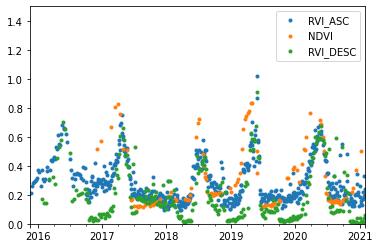

In [9]:
%matplotlib inline
plot = joined_df.plot(marker='.', linestyle='None')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1.5])
ax.set_xlabel("")
ax.get_legend()

In [129]:
def pre_MOGPR(df, tstep):
    """
    Preprocessing of a pandas dataframe to serve as input to MOGRP_GPY_retrieval

    Args:
      df : pandas dataframe with the signals. A set index is mandatory.
      tstep[int] : step of days for the output
    Returns:
      data : Array containing the data of the signals
      time : Array containing the dates of the input signals(ordinal)
      output_time : Array containing the dates of the output signals(dates)
      output_timevec : Array containing the dates of the input signals(ordinal)
      var_names : List containing the names of the signals
    """ 
    time       = []
    data       = []
    time_str   = []
    var_names  = []

    for column in df:
        time_vec_num = np.asarray([ _.toordinal() for _ in df.index], dtype=np.float64)        
        time.append(time_vec_num)
        data.append(np.reshape(df[column].to_numpy(),(df.shape[0],1,1)))        
        var_names.append(column)       
    
    time_vec_min        = np.min(list(pd.core.common.flatten(time)))
    time_vec_max        = np.max(list(pd.core.common.flatten(time)))
    output_timevec      = np.array(range(int(time_vec_min), int(time_vec_max), tstep), dtype = np.float64)  
    output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]
    
    return data, time, output_time, output_timevec, var_names

def MOGPR_GPY_retrieval(data_in, time_in, master_ind, output_timevec, nt):
    """
    Function performing the multioutput gaussian-process regression at pixel level for gapfilling purposes

    Args:
      data_in [array] : 3D (2DSpace, Time) array containing data to be processed 
      time_in [array] : vector containing the dates of each layer in the time dimension
      master_ind [int] : Index identifying the Master output
      output_timevec [array] :vector containing the dates on which output must be estimated
      nt [int]  : # of time the GP training must be performed (def=1)      
    Returns:
      Out_mean [array] : 3D (2DSpace, Time) mean value of the prediction at pixel level
      Out_std [array]  : 3D (2DSpace, Time) standard deviation  of the prediction at pixel level
      Out_QFlag [array]: 2D map of Quality Flag for any numerical error in the model determination
      Out_model [list] : Matrix-like structure containing the model information at pixel level       
    """   
    noutput_timeseries = len(data_in)    
    x_size = data_in[0].shape[1]    
    y_size = data_in[0].shape[2]    
    imout_sz = (output_timevec.shape[0],x_size,y_size)
    
    Xtest     = output_timevec.reshape(output_timevec.shape[0],1)    
    out_qflag = np.ones((x_size,y_size), dtype=bool)
    
    out_mean  = []
    out_std   = []
    out_model = [[0] * y_size for _ in range(x_size)]

    #Variable is initialized to take into account possibility that within one block no valid pixels is present, due to the mask
    for _ in range(noutput_timeseries):        
        out_mean.append(np.full(imout_sz,np.nan))
        out_std.append(np.full(imout_sz,np.nan))
    
    for x, y in itertools.product(range(x_size), range(y_size)):

        X_vec = []
        Y_vec = []
        Y_mean_vec = []
        Y_std_vec  = []

        for ind in range(noutput_timeseries):

            X_tmp  = time_in[ind]
            Y_tmp  = data_in[ind][:,x,y] 
            X_tmp  = X_tmp[~np.isnan(Y_tmp),np.newaxis]
            Y_tmp  = Y_tmp[~np.isnan(Y_tmp),np.newaxis]
            X_vec.append(X_tmp)
            Y_vec.append(Y_tmp)
            del X_tmp,Y_tmp

        if np.size(Y_vec[master_ind])>0:
            # Data Normalization
            for ind in range(noutput_timeseries):
                Y_mean_vec.append(np.mean(Y_vec[ind])) 
                Y_std_vec.append(np.std(Y_vec[ind]))
                Y_vec[ind] = (Y_vec[ind]-Y_mean_vec[ind])/Y_std_vec[ind]

            # Multi-output train and test sets
            Xtrain = X_vec
            Ytrain = Y_vec

            nsamples, npixels = Xtest.shape            
            noutputs = len(Ytrain)

            for i_test in range(nt):
                Yp = np.zeros((nsamples, noutputs))
                Vp = np.zeros((nsamples, noutputs))
                K = GPy.kern.Matern32(1)
                LCM = GPy.util.multioutput.LCM(input_dim=1, num_outputs=noutputs, kernels_list=[K]*noutputs, W_rank=1)
                model = GPy.models.GPCoregionalizedRegression(Xtrain, Ytrain, kernel=LCM.copy())  
                if not np.isnan(Ytrain[1]).all():
                    try:
                        #if trained_model is None:
                        model.optimize()
                        list_tmp = [model.param_array]                        
                        for _ in range(noutput_timeseries):
                            list_tmp.append(eval('model.sum.ICM'+str(_)+'.B.B'))
                        out_model[x][y]=list_tmp

                    except:
                        out_qflag[x,y]=False
                        continue

                    for out in range(noutputs):
                        newX = Xtest.copy() 
                        newX = np.hstack([newX, out * np.ones((newX.shape[0], 1))])
                        
                        noise_dict = {'output_index': newX[:, -1:].astype(int)}                        
                        Yp[:,None, out],Vp[:,None,out] =model.predict(newX, Y_metadata=noise_dict)                        

                    if i_test==0:
                        for ind in range(noutput_timeseries):
                            out_mean[ind][:,None,x,y] = (Yp[:,None, 0]*Y_std_vec[ind]+Y_mean_vec[ind])/nt       
                            out_std[ind][:,None,x,y]  = (Vp[:,None, 0]*Y_std_vec[ind])/nt       
                    else:
                        for ind in range(noutput_timeseries):
                            out_mean[ind][:,None,x,y] = out_mean[ind][:,None,x,y] + (Yp[:,None, 0]*Y_std_vec[ind]+Y_mean_vec[ind])/nt       
                            out_std[ind][:,None,x,y]  = out_std[ind][:,None,x,y]  + (Vp[:,None, 0]*Y_std_vec[ind])/nt        

                    del Yp,Vp

    return  out_mean, out_std, out_qflag, out_model

def post_MOGPR(out_mean, out_std, output_dates, var_names):
    """
    Post-processing MOGPR to built the output dataframes

    Args:
      out_mean [array] : Predicted mean of each of the variables
      out_std [array] : Uncertainty of each of the variables
      output_dates [array] : Dates of the outputs corresponding to out_mean, out_std
      var_names [array] : Names of the input/output signals
      
    Returns:
      df_mogpr_out_mean [Dataframe] : Predicted mean(with index)
      df_mogpr_out_std [Dataframe]  : Uncertainty(with index)
    """   
    # Predicted mean
    nout = len(out_mean)
    out_mean_list = []
    for ind in range(nout):
        out_mean_list.append(out_mean[ind].ravel())

    df_mogpr_out_mean = pd.DataFrame(np.column_stack(out_mean_list), columns = var_names)
    df_mogpr_out_mean.index = output_dates
    
    # Uncertainties
    out_std_list = []
    for ind in range(nout):
        out_std_list.append(out_std[ind].ravel())

    df_mogpr_out_std = pd.DataFrame(np.column_stack(out_std_list), columns = var_names)
    df_mogpr_out_std.index = output_dates    
    
    return df_mogpr_out_mean, df_mogpr_out_std
 
def process_chain_MOGPR(input_df, master_ind, nt, day_step):
    """
    Wrapper containing all the steps of the MOGPR

    Args:
      input_df [Dataframe] : Input dataframe containing the signals to be processed
      master_ind [int] : Index identifying the Master output
      nt [int] : # of time the GP training must be performed      
      day_step [int] : step of days for the output
      
    Returns:
      df_mogpr_out_mean [Dataframe] : Predicted mean(with index)
      df_mogpr_out_std [Dataframe]  : Uncertainty(with index)
    """   
    data, dates, output_dates, output_dates_vec, var_names = pre_MOGPR(input_df, day_step)
    out_mean, out_std, out_qflag, out_model = MOGPR_GPY_retrieval(data[:], dates[:], master_ind, output_dates_vec, nt)
    mogpr_mean_out_df, df_mogpr_out_std = post_MOGPR(out_mean, out_std, output_dates, var_names)
    return mogpr_mean_out_df, df_mogpr_out_std

### Execution

In [130]:
# Filter Dataframe
signals = ['RVI_DESC', 'NDVI']
filtered_df = joined_df[signals].loc['2016-01-01':'2020-01-20'].copy()
filtered_df

,RVI_DESC,NDVI
date,,
2016-01-01 00:00:00+00:00,NaN,NaN
2016-01-02 00:00:00+00:00,NaN,NaN
2016-01-03 00:00:00+00:00,NaN,NaN
2016-01-04 00:00:00+00:00,NaN,NaN
2016-01-05 00:00:00+00:00,NaN,NaN
...,...,...
2020-01-16 00:00:00+00:00,NaN,NaN
2020-01-17 00:00:00+00:00,NaN,NaN
2020-01-18 00:00:00+00:00,0.053706,NaN


In [132]:
master_ind = 1
nt = 1
day_step = 15

print('MOGPR Being calculated')    
mogpr_mean_out_df,_ = process_chain_MOGPR(filtered_df, master_ind, nt, day_step)

MOGPR Being calculated


Plot the results

(0.0, 1.0)

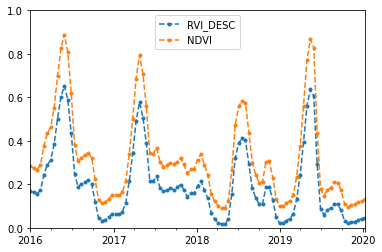

In [133]:
plot = mogpr_mean_out_df.plot(marker='.', linestyle='--')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])